In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -a gdrive/MyDrive/Data\ Science\ Utils/. .

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import imageio
import glob
import skimage
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import json

from skimage.transform import *
from skimage.color import *
from skimage.filters import threshold_mean

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rtatman/stamp-verification-staver-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip stamp-verification-staver-dataset.zip

unzip:  cannot find or open stamp-verification-staver-dataset.zip, stamp-verification-staver-dataset.zip.zip or stamp-verification-staver-dataset.zip.ZIP.


In [ ]:
# %%
path_to_data = ""
SCANS_DIR = path_to_data + "./scans/scans/"
TRUTH_DIR = path_to_data + "./ground-truth-pixel/ground-truth-pixel/"


# IMG_SIZE = (2302, 1632, 3)

IMG_SIZE = (2304, 1632, 3)
# IMG_SIZE = (1152, 816, 3)

scan_files = glob.glob(SCANS_DIR + '*.png')
scan_files = sorted(scan_files)
scan_files_train = scan_files[:400]
scan_files_test = scan_files[400:]
truth_files = glob.glob(TRUTH_DIR + '*.png')
truth_files = sorted(truth_files)

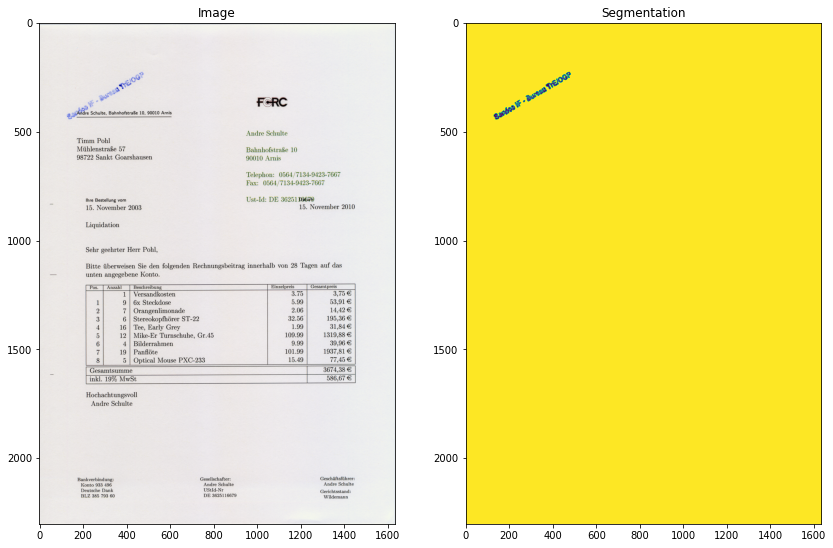

In [ ]:
N = 2
img = imageio.imread(scan_files[N])
mask = imageio.imread(truth_files[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

In [ ]:
scan_files_train_selected = scan_files_train[0:400]
truth_files_selected = truth_files[0:400]
pd.DataFrame({'scan': scan_files_train_selected, 'truth': truth_files_selected}).tail()

scan  \
395  ./scans/scans/stampDS-00396.png   
396  ./scans/scans/stampDS-00397.png   
397  ./scans/scans/stampDS-00398.png   
398  ./scans/scans/stampDS-00399.png   
399  ./scans/scans/stampDS-00400.png   

                                                 truth  
395  ./ground-truth-pixel/ground-truth-pixel/stampD...  
396  ./ground-truth-pixel/ground-truth-pixel/stampD...  
397  ./ground-truth-pixel/ground-truth-pixel/stampD...  
398  ./ground-truth-pixel/ground-truth-pixel/stampD...  
399  ./ground-truth-pixel/ground-truth-pixel/stampD...

In [ ]:
def calc_sample_weight(label, image):
    image = rgb2gray(image)
    around_texts = cv2.dilate((image < 0.5).astype(np.uint8) | label, np.ones((2, 2)))
    combined = around_texts + label
    class_counts = np.unique(combined, return_counts=True)[1]
    class_weight = np.sum(class_counts) / class_counts * np.array([1, 1, 2])[:len(class_counts)]
    # class_weight = class_weight / np.max(class_weight)
    weights = np.vectorize(lambda x: class_weight[x])(combined).flatten()
    # weights = np.vectorize(lambda x: class_weight[x])(combined)
    return weights, class_counts, class_weight

In [ ]:
def image_generator(files,
                    randomized=True,
                    labels=None,
                    include_weights=False,
                    batch_size=1,
                    augment=False,
                    gamma_range=(1, 1),
                    jitter_range = 0,
                    rotation_angle=5,
                    scale_range = (0.9, 1)):
    img_batch = []
    label_batch = []
    weight_batch = []
    while True:
        indices = range(len(files))
        if randomized:
            indices = np.random.randint(len(files), size=len(files))
        for i in indices:
            if len(img_batch) >= batch_size:
                img_batch = []
                label_batch = []
                weight_batch = []
            img = imageio.imread(files[i])

            dim = (IMG_SIZE[1], IMG_SIZE[0])
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

            img = img / 255

            label = None
            if labels is not None:
                label = imageio.imread(labels[i])
                label = cv2.resize(label, dim, interpolation=cv2.INTER_NEAREST)

                label = (255 - label) / 255
                label = label[:, :, 0].astype(np.uint8)

            if augment:
                img = img ** np.random.uniform(gamma_range[0], gamma_range[1])
                rows, cols, _ = img.shape

                # Random Rotation and Scale
                rotation = np.random.uniform(-rotation_angle, rotation_angle)
                scale = np.random.uniform(scale_range[0], scale_range[1])

                rotation_matrix = cv2.getRotationMatrix2D(((cols - 1) / 2.0,
                                                           (rows - 1) / 2.0),
                                                          rotation, scale)

                img = cv2.warpAffine(img, rotation_matrix, (cols, rows),
                                     flags=cv2.INTER_NEAREST)

                # Jitter
                jitter = np.random.uniform(0, jitter_range, (4, 2)).astype(np.float32)
                pts1 = np.array(((0, 0),
                                 (IMG_SIZE[1], 0),
                                 (0, IMG_SIZE[0]),
                                 (IMG_SIZE[1], IMG_SIZE[0]))
                                ).astype(np.float32)
                pts2 = pts1 + jitter
                M = cv2.getPerspectiveTransform(pts1, pts2)
                img = cv2.warpPerspective(img, M, (IMG_SIZE[1], IMG_SIZE[0]),
                                          borderValue=(1, 1, 1))

                if labels is not None:
                    # Rotation
                    label = cv2.warpAffine(label, rotation_matrix, (cols, rows),
                                           flags=cv2.INTER_NEAREST)
                    # Jitter
                    label = cv2.warpPerspective(label, M, (IMG_SIZE[1], IMG_SIZE[0]),
                                                flags=cv2.INTER_NEAREST, borderValue=0)

            img_batch.append(img)
            if labels is not None:
                if include_weights:
                    # weight_batch.append(calc_sample_weight(label, img)[0].reshape((IMG_SIZE[1], IMG_SIZE[0], 1)))
                    weight_batch.append(calc_sample_weight(label, img)[0])

                # label_batch.append(label.reshape((IMG_SIZE[1], IMG_SIZE[0], 1)))
                label_batch.append(label.reshape((IMG_SIZE[1] * IMG_SIZE[0], 1)))
            if len(img_batch) >= batch_size:
                if labels is not None:
                    if include_weights:
                        yield np.array(img_batch), np.array(label_batch), np.array(weight_batch)
                    else:
                        yield np.array(img_batch), np.array(label_batch)
                else:
                    yield np.array(img_batch)

In [ ]:
sanity_check_iterator = image_generator(scan_files_train_selected,
                                        labels=truth_files_selected,
                                        include_weights=True,
                                        batch_size=1,
                                        augment=True,
                                        randomized = False,
                                        gamma_range=(0.8, 0.8),
                                        jitter_range=50,
                                        rotation_angle=5,
                                        scale_range = (0.9, 1))

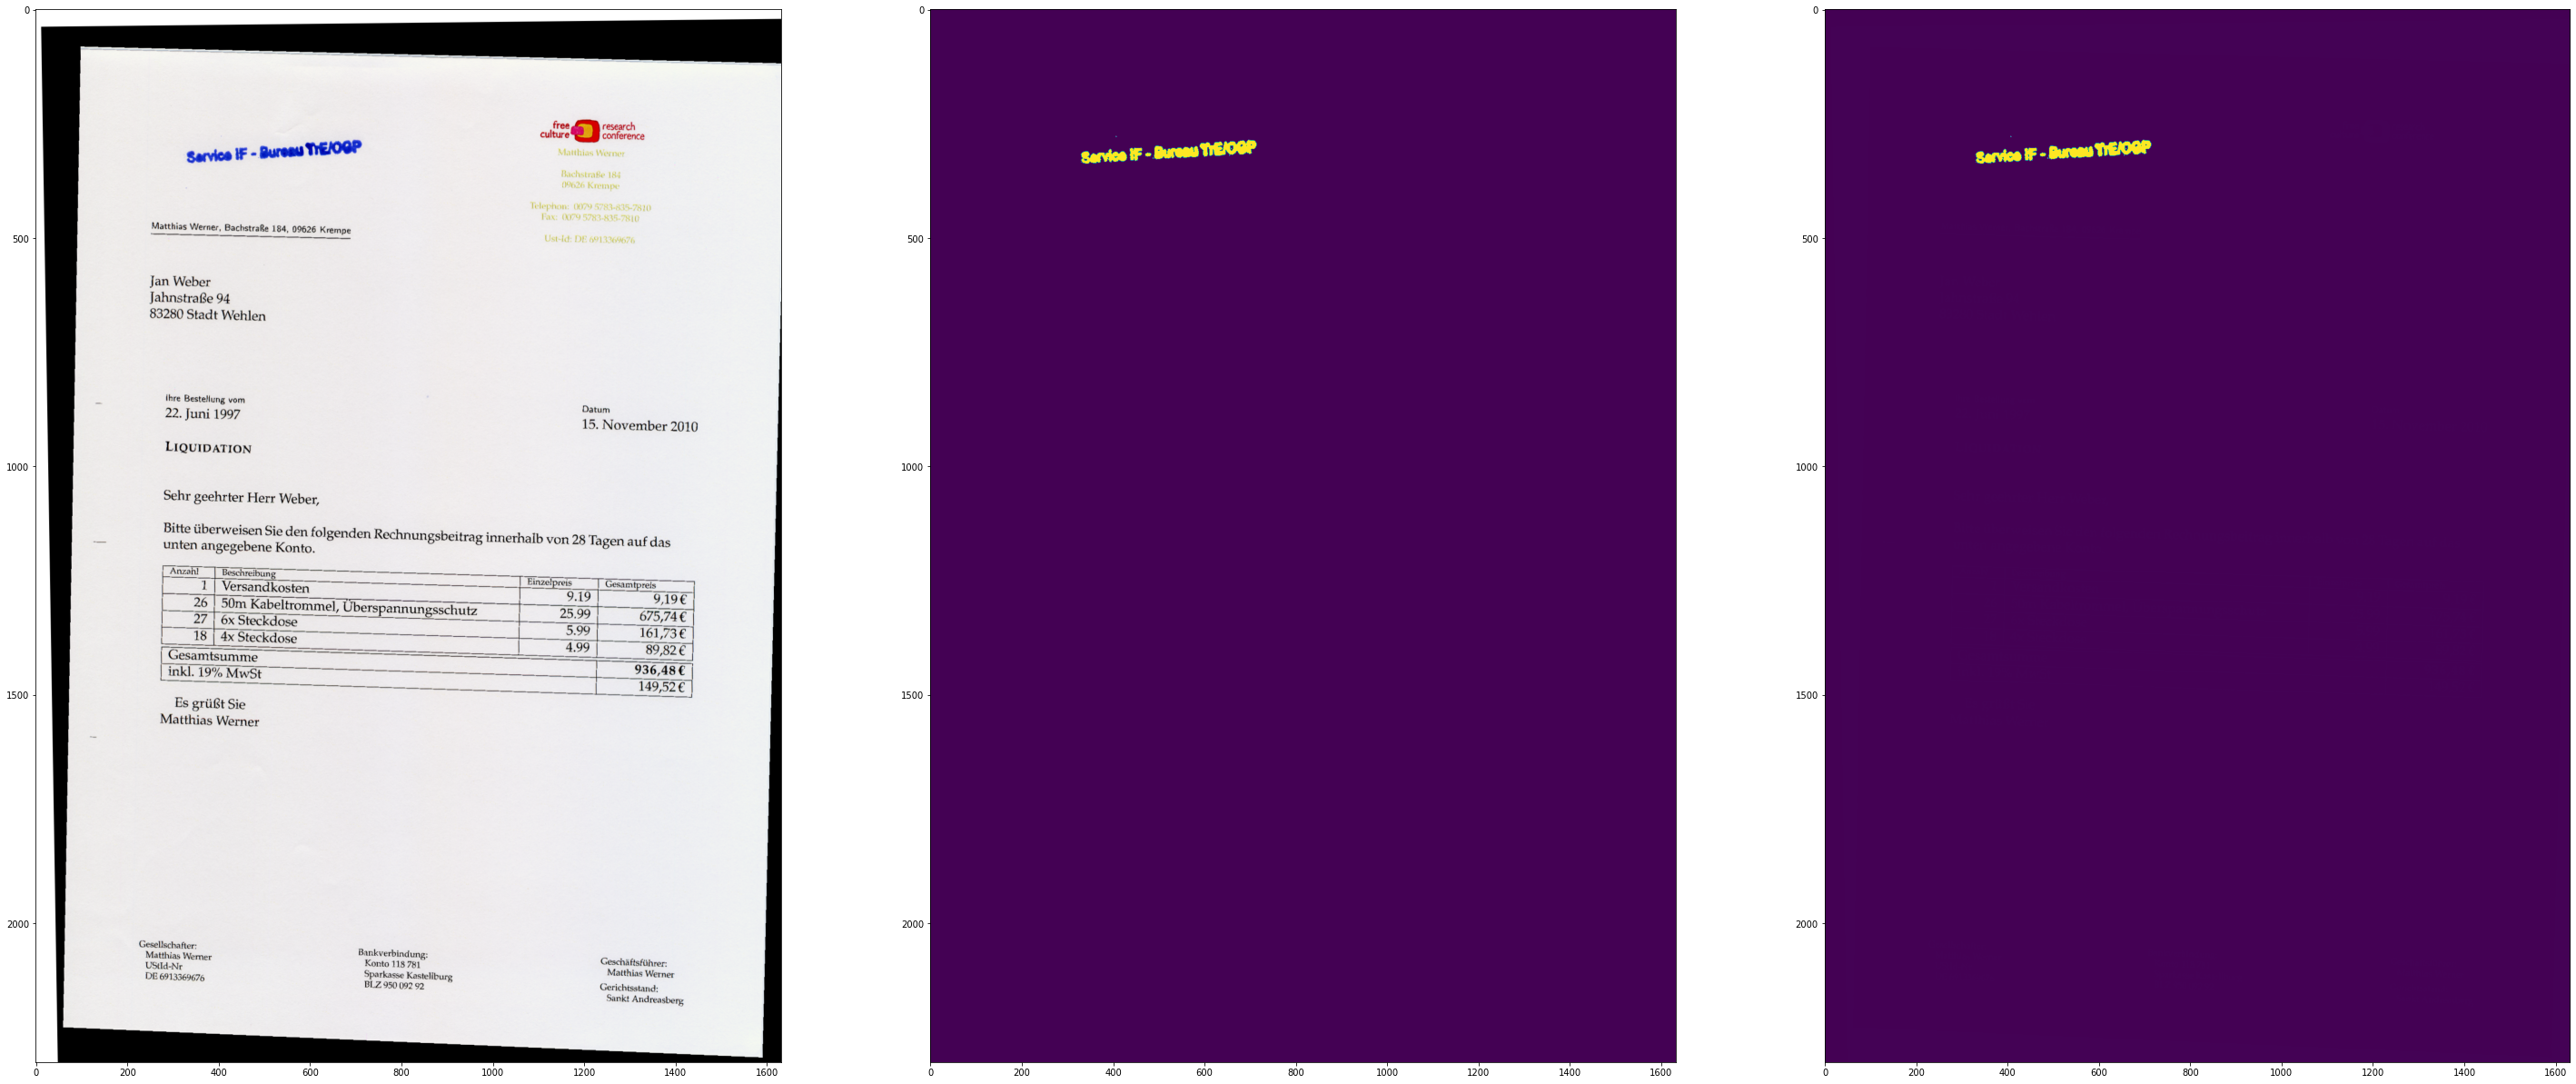

In [ ]:
scans, labels, weights = next(sanity_check_iterator)

plt.figure(figsize=(50, 50))
plt.subplot(1, 3, 1)
plt.imshow(scans[0]);
plt.subplot(1, 3, 2)
plt.imshow(labels[0].reshape((IMG_SIZE[0], IMG_SIZE[1])));
plt.subplot(1, 3, 3)
plt.imshow(weights[0].reshape((IMG_SIZE[0], IMG_SIZE[1])));
plt.show()

In [ ]:
print(weights.shape)
print(labels.shape)
print(scans.shape)

(1, 3760128)
(1, 3760128, 1)
(1, 2304, 1632, 3)


In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0., max_pooling=True, batch_normalization = True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if batch_normalization:
        conv = BatchNormalization()(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, batch_normalization = True):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
        n_filters,  # number of filters
        3,  # Kernel size
        strides=(2, 2),
        padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if batch_normalization:
       conv = BatchNormalization()(conv)

    return conv


In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=2):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """

    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters, 
                   kernel_size = 3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    # Mozna tahle? Odstranil jsem jednu conv2D vrstvy z jiny architektury.
    # conv9 = ublock9

    conv10 = Conv2D(n_classes, 1, padding='same', activation = "sigmoid")(conv9)
    x = Reshape((IMG_SIZE[0] * IMG_SIZE[1], 1,))(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [ ]:
img_height = IMG_SIZE[0]
img_width = IMG_SIZE[1]
num_channels = 3
n_filters = 8
metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 
         "accuracy",
         tf.keras.metrics.Recall(), 
         tf.keras.metrics.Precision()]

input_size = (img_height, img_width, num_channels)
input_size

(2304, 1632, 3)

In [ ]:
unet = unet_model(input_size, n_filters=n_filters, n_classes=1)

In [ ]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2304, 1632,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_58 (Conv2D)             (None, 2304, 1632,   224         ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2304, 1632,   584         ['conv2d_58[0][0]']              
                                8)                                                          

In [ ]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)

pridal jsem sample weight z jiny architektury

In [ ]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)

In [ ]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
timestamp = "2022_04_21_15_47_08"

In [ ]:
folder_to_save = "gdrive/MyDrive/saved_models/unet_3/" + timestamp + "/"
if not os.path.isdir(folder_to_save):
  os.mkdir(folder_to_save)

In [ ]:
with open(folder_to_save + "model_stats.txt", "w") as stream:
  unet.summary(print_fn=lambda x: stream.write(x + '\n'))

In [ ]:
BATCH_SIZE = 5
EPOCHS = 20

In [ ]:
config = {"EPOCHS" : EPOCHS, 
          "BATCH_SIZE" : BATCH_SIZE,
          "IMG_SIZE" : IMG_SIZE,
          "n_filters" : n_filters,
          "loss_function" : "BinaryCrossentropy",
          "optimizer" : "adam",
          "metrics" : ["recall", "MeanIoU(num_classes=2)", "accuracy"]}

with open(folder_to_save + "model_config.txt", "w") as stream:
  stream.write(json.dumps(config))

In [ ]:
train_set = image_generator(scan_files_train_selected,
                            labels=truth_files_selected,
                            include_weights=True,
                            batch_size=BATCH_SIZE,
                            augment=True,
                            gamma_range=(0.8, 1.25),
                            jitter_range=50,
                            rotation_angle=5,
                            scale_range = (0.9, 1))

validation_set = image_generator(scan_files_train_selected,
                                 labels=truth_files_selected,
                                 include_weights=True,
                                 batch_size=1,
                                 augment=True,
                                 gamma_range=(0.8, 1.25),
                                 jitter_range=50,
                                 rotation_angle=5,
                                 scale_range = (0.9, 1))

In [ ]:
model_history = unet.fit(train_set,
                         validation_data=validation_set,
                         validation_steps=3,
                         steps_per_epoch=len(scan_files_train_selected) // BATCH_SIZE,
                         max_queue_size=1,
                         epochs=EPOCHS,
                         verbose = True,
                         callbacks=[ModelCheckpoint(folder_to_save + 'stamp.weights.{epoch:04d}.hdf5', save_weights_only=True)], )

Epoch 1/20
80/80 [==============================] - 744s 9s/step - loss: 2.0803 - mean_io_u_13: 0.5210 - accuracy: 0.9672 - recall_13: 0.9279 - precision_1: 0.0443 - val_loss: 2.1609 - val_mean_io_u_13: 0.4994 - val_accuracy: 0.9538 - val_recall_13: 0.8815 - val_precision_1: 0.0215
Epoch 2/20
80/80 [==============================] - 733s 9s/step - loss: 1.9598 - mean_io_u_13: 0.5635 - accuracy: 0.9896 - recall_13: 0.9794 - precision_1: 0.1340 - val_loss: 2.3814 - val_mean_io_u_13: 0.4994 - val_accuracy: 0.9057 - val_recall_13: 0.9120 - val_precision_1: 0.0114
Epoch 3/20
80/80 [==============================] - 733s 9s/step - loss: 1.9669 - mean_io_u_13: 0.5925 - accuracy: 0.9911 - recall_13: 0.9745 - precision_1: 0.1582 - val_loss: 2.3777 - val_mean_io_u_13: 0.4995 - val_accuracy: 0.9032 - val_recall_13: 0.8398 - val_precision_1: 0.0082
Epoch 4/20
80/80 [==============================] - 736s 9s/step - loss: 1.9694 - mean_io_u_13: 0.6026 - accuracy: 0.9925 - recall_13: 0.9864 - precisi

In [ ]:
import csv

with open(folder_to_save + 'mycsvfile.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, model_history.history.keys())
    w.writeheader()
    w.writerow(model_history.history)

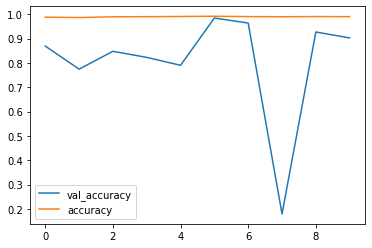

In [ ]:
plt.plot(model_history.history["val_accuracy"], label = "val_accuracy")
plt.plot(model_history.history["accuracy"], label = "accuracy")
plt.legend()
plt.show()

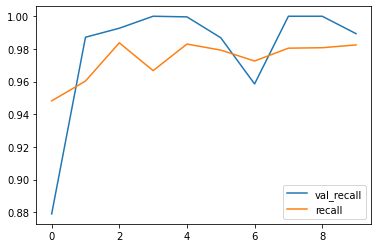

In [ ]:
plt.plot(model_history.history["val_recall_6"], label = "val_recall")
plt.plot(model_history.history["recall_6"], label = "recall")
plt.legend()
plt.show()

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'recall_6', 'mean_io_u_6', 'accuracy', 'val_loss', 'val_recall_6', 'val_mean_io_u_6', 'val_accuracy'])

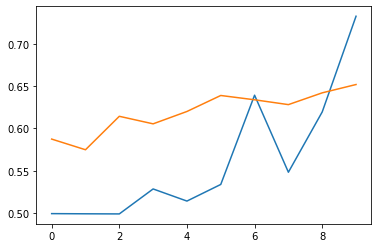

In [ ]:
plt.plot(model_history.history["val_mean_io_u_6"], label="val_iou")
plt.plot(model_history.history["mean_io_u_6"], label="train_iou")
plt.legend()
plt.show()

In [ ]:
np.argmax(model_history.history["val_mean_io_u_6"])

9

In [ ]:
steps=len(scan_files_test[0:10])
checkpoints = sorted(glob.glob(folder_to_save + '*.hdf5'))
rows = len(checkpoints)+1
# checkpoints = [x for x in checkpoints[::5]] + [checkpoints[13]]
checkpoints

['gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0001.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0002.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0003.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0004.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0005.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0006.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0007.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0008.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0009.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0010.hdf5',
 'gdrive/MyDrive/saved_models/unet_3/2022_04_21_15_47_08/stamp.weights.0011.hdf5']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


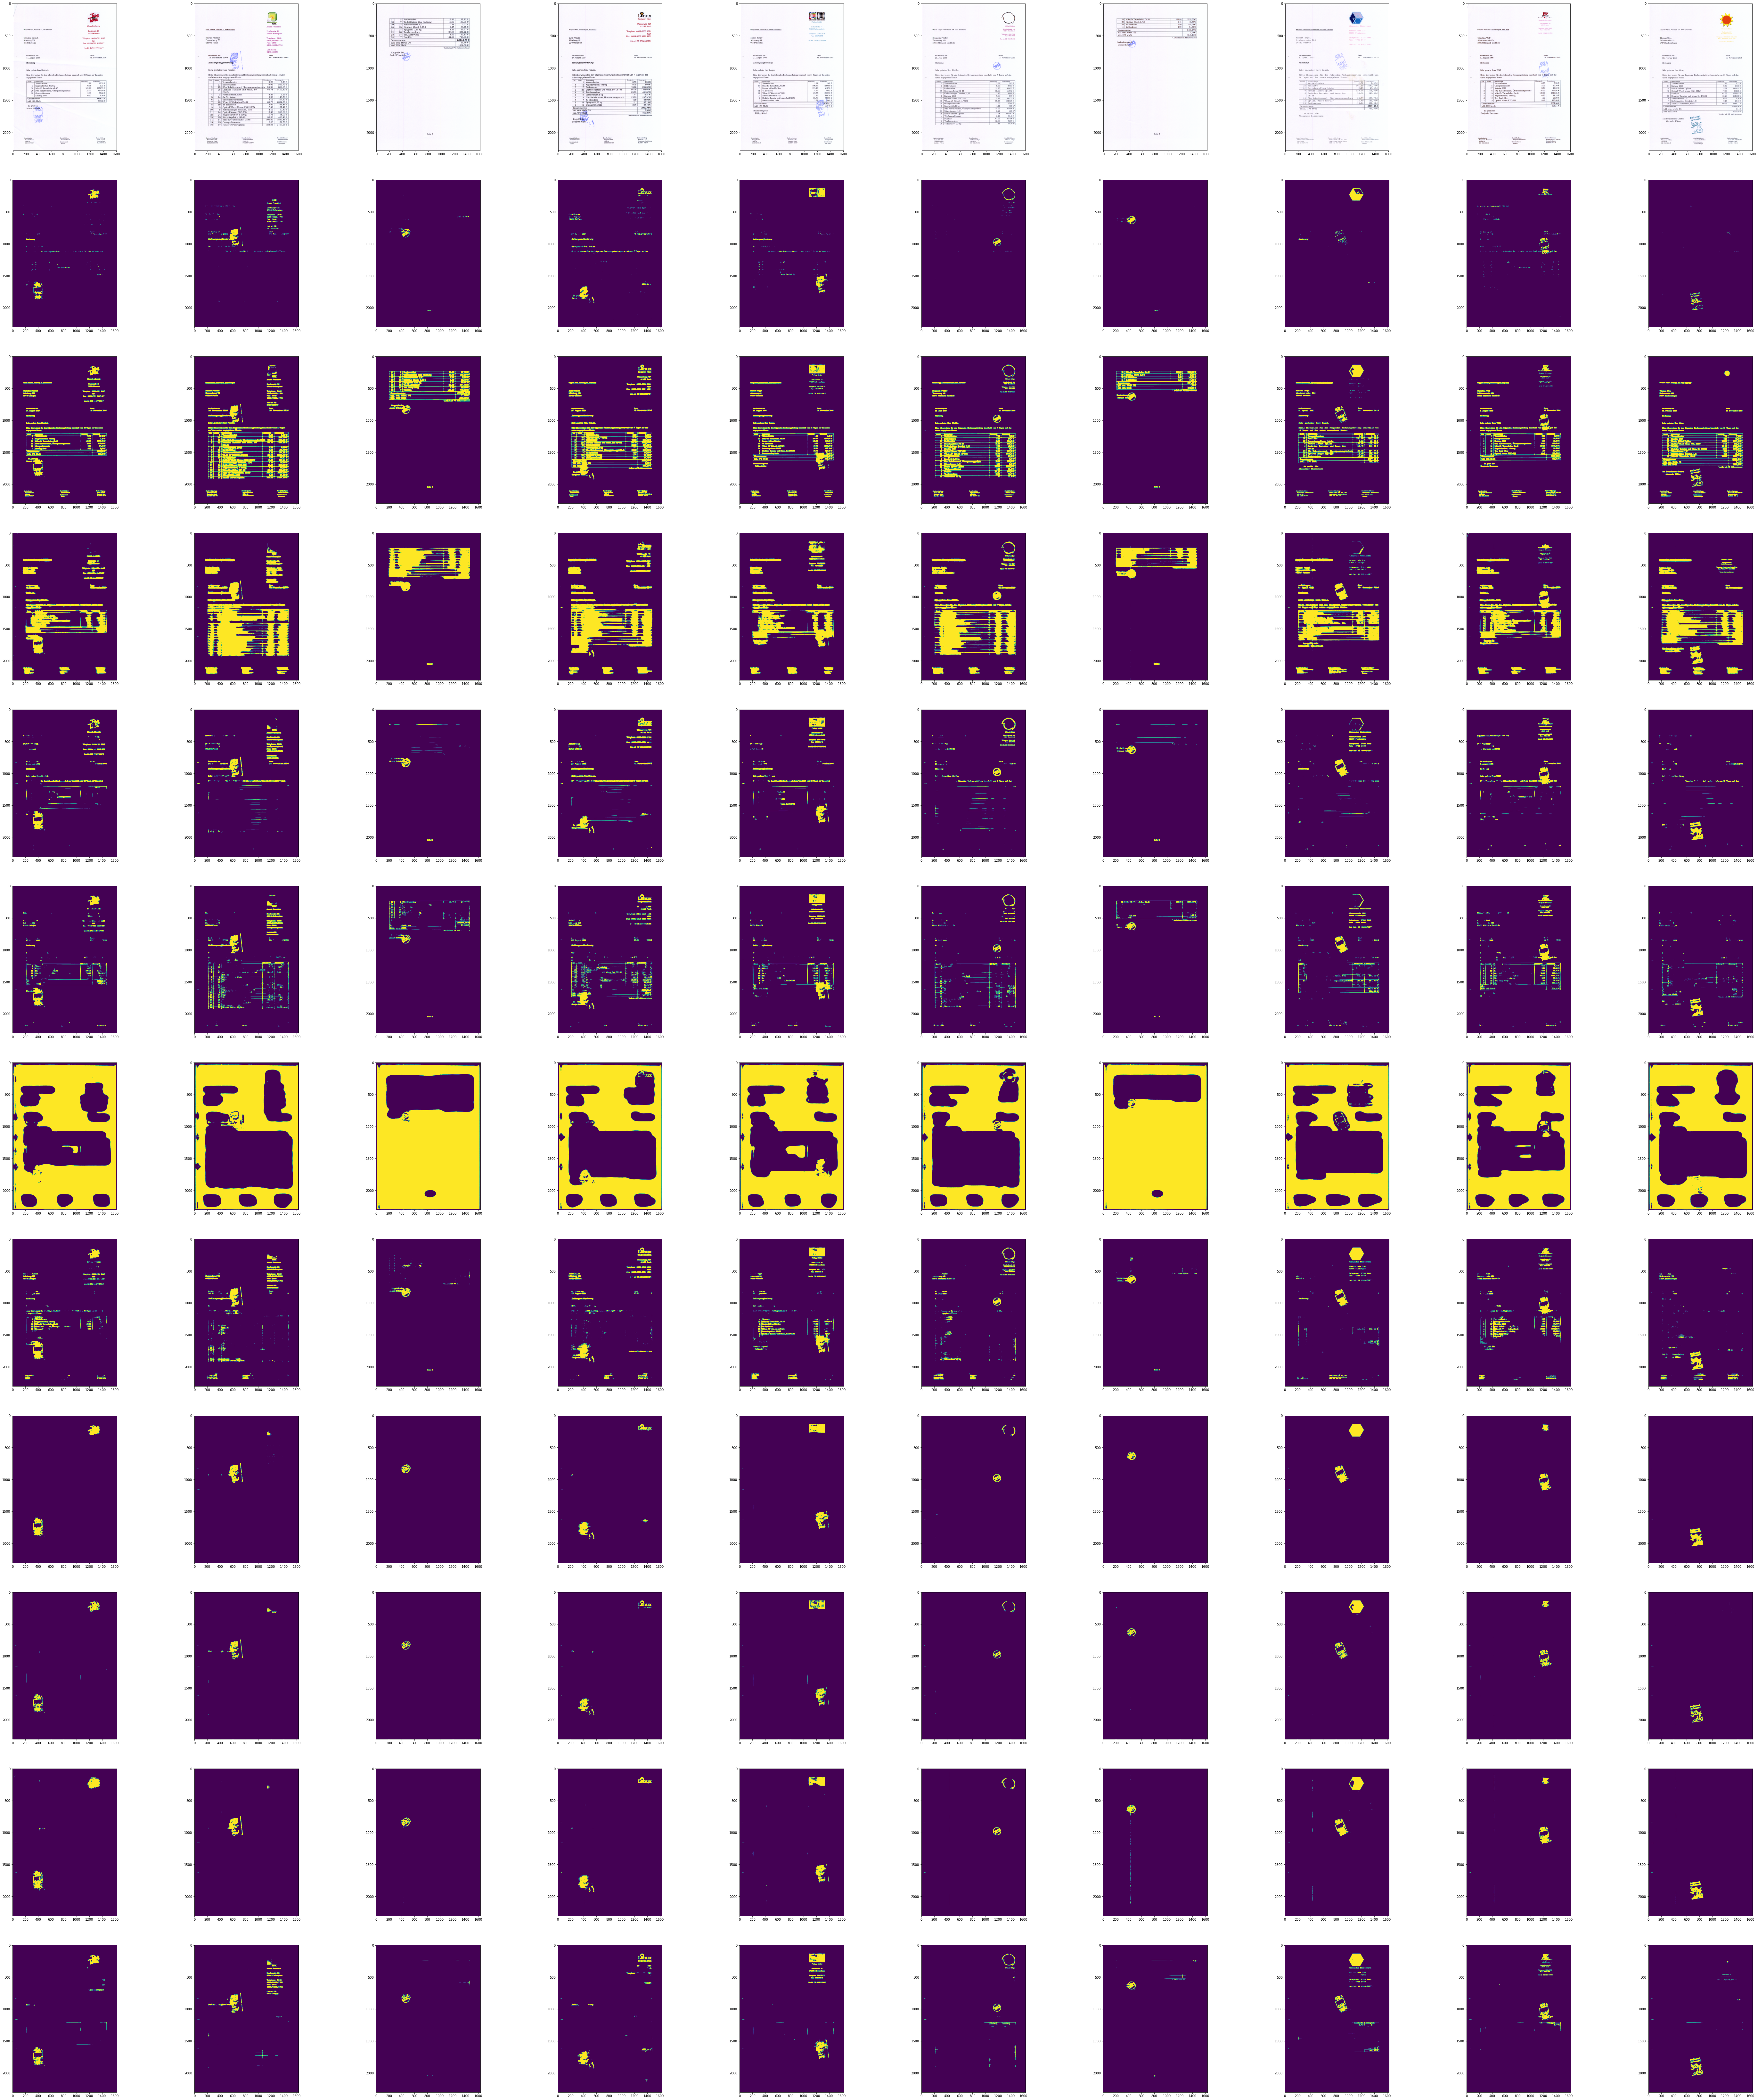

In [ ]:
plt.figure(figsize=(steps*10, rows*10))
for i in range(steps):
    plt.subplot(rows,steps,i+1)
    plt.imshow(imageio.imread(scan_files_test[i]))
for i, c in enumerate(checkpoints):
    unet.load_weights(c)
    predicted = unet.predict_generator(image_generator(scan_files_test,randomized=False, labels=None, include_weights=False, batch_size=1, augment=False),
                       steps=steps)
    predicted = np.round(predicted).reshape((steps,IMG_SIZE[0],IMG_SIZE[1]))
    for s in range(steps):
        plt.subplot(rows,steps,i*steps+s+steps+1)
        plt.imshow(predicted[s])

In [ ]:
predicted = np.round(predicted).reshape((steps,IMG_SIZE[0],IMG_SIZE[1]))

In [ ]:
c = 'gdrive/MyDrive/saved_models/unet_3/2022_04_20_11_46_40/stamp.weights.0013.hdf5'
unet.load_weights(c)
predicted = unet.predict_generator(image_generator(scan_files_test,randomized=False, labels=None, include_weights=False, batch_size=1, augment=False), steps=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


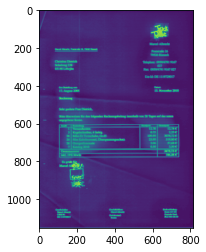

In [ ]:
predicted = np.round(predicted).reshape((1,IMG_SIZE[0],IMG_SIZE[1]))
plt.imshow(predicted[0])

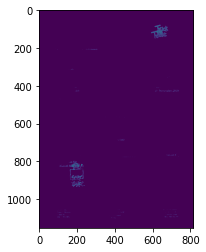

In [ ]:
predicted[0][predicted[0] < 0] = 0
plt.imshow(predicted[0])